# Notebook 01: Exploratory Data Analysis

## Short description of the notebook

# NOTES
What we have done:

- Preliminary data inspection

- Add missing data to LLL1
  - Several classic methods tried with low accuracy
  - Imputation with Iterative imputer is good
  - Cannot find anything like LLL1 to extract the real missing data

# Dependencies

In [5]:
# Standard library
import os
import sys
import warnings
import random
import logging
import pickle

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Others
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from typing import List, Optional, Union


# General Setup

In [6]:
%%bash
cd /content

REPO=https://github.com/jacopo-raffaeli/portfolio-replica.git
DIR=portfolio-replica

# Clone if needed, else pull latest
if [ ! -d "$DIR" ]; then
  git clone $REPO > /dev/null 2>&1
else
  cd $DIR
  git pull origin main > /dev/null 2>&1
  cd ..
fi

# Enter project root and install dependencies
cd $DIR
pip install -r requirements.txt > /dev/null 2>&1


In [7]:
# Add repo root to sys.path for imports
PROJECT_ROOT = "/content/portfolio-replica"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

# Set working directory for relative paths
os.chdir(PROJECT_ROOT)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/portfolio-replica


In [8]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 3)

# Seaborn and Matplotlib display options
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Set reproducible seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# Define paths
data_raw_path = "data/raw/"
data_interim_path = "data/interim/"
data_processed_path = "data/processed/"

# Utilities

In [57]:
def impute_series_with_lag(
    df: pd.DataFrame,
    target_col: str,
    corruption_start_idx: int,
    min_corr: float = 0.2,
    max_features: int = 3,
    lag: int = 1,
    random_state: Optional[int] = 42,
    round_digits: Optional[int] = 1
) -> pd.Series:

    """
    Impute missing values in a time series using IterativeImputer with lagged features.

    Parameters
    ----------
    df : pd.DataFrame
        Full input DataFrame including the target column.
    target_col : str
        Name of the target column to impute (e.g., "LLL1 Comdty").
    corruption_start_idx : int
        Index (positional) at which to start treating target_col as missing.
    min_corr : float, optional
        Minimum absolute correlation for a feature to be included.
    max_features : int, optional
        Maximum number of top correlated features to use.
    lag : int, optional
        Lag for lagged features.
    random_state : int, optional
        Random seed for reproducibility.
    round_digits : int or None, optional
        If not None, round imputed values to this number of decimal digits.

    Returns
    -------
    pd.Series
        Imputed time series (same length as input).
    """

    df_copy = df.copy()
    target_series = df_copy[target_col].copy()
    target_series.iloc[corruption_start_idx:] = np.nan

    df_lagged = df_copy.copy()
    df_lagged["__target_fixed__"] = target_series

    # Correlation-based feature selection
    corr_matrix = df_lagged.iloc[:corruption_start_idx].corr()
    correlations = corr_matrix["__target_fixed__"].drop("__target_fixed__").dropna()
    top_features = correlations[correlations.abs() > min_corr]
    selected_features = top_features.head(max_features).index.tolist()

    # Add lagged features
    lagged_cols = []
    for col in selected_features + ["__target_fixed__"]:
        lagged_col = f"{col}_lag"
        df_lagged[lagged_col] = df_lagged[col].shift(lag)
        lagged_cols.append(lagged_col)

    imputation_data = df_lagged[lagged_cols].copy()

    imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=random_state)
    imputed_array = imp.fit_transform(imputation_data)

    target_lagged_col = f"__target_fixed___lag"
    imputed_target_lagged = imputed_array[:, lagged_cols.index(target_lagged_col)]

    # Shift back to get original timing
    imputed_target = pd.Series(imputed_target_lagged, index=df.index).shift(-lag)
    imputed_target.iloc[:lag] = target_series.iloc[:lag]  # preserve initial values

    if round_digits is not None:
        imputed_target = np.round(imputed_target, round_digits)

    return pd.Series(imputed_target, index=df.index, name=f"{target_col}_imputed")


# Load & Inspect Dataset

In [10]:
# Read full names (row 4)
full_names_df = pd.read_excel(data_raw_path + "dataset_raw.xlsx", header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]
# Read Bloomberg tickers (row 5)
tickers_df = pd.read_excel(data_raw_path + "dataset_raw.xlsx", header=None, skiprows=4, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]
# Create and save a dictionary mapping tickers to full names
tickers_name_dict = dict(zip(tickers, full_names))
with open(data_processed_path + "tickers_name_dict.pkl", "wb") as f:
    pickle.dump(tickers_name_dict, f)

# Read the actual data without using any row as a header (from row 6)
df_raw = pd.read_excel(data_raw_path + "dataset_raw.xlsx", header=None, skiprows=5)
# Set column names and index
df_raw.columns = ['Date'] + tickers
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%d/%m/%Y')
df_raw = df_raw.set_index('Date')

In [62]:
print("Dataset shape:", df_raw.shape)
print(f"From {df_raw.index.min()} to {df_raw.index.max()}, total days: {df_raw.shape[0]}")
display(df_raw.index.to_series().diff().value_counts().head())
display(df_raw.head())

Dataset shape: (705, 15)
From 2007-10-23 00:00:00 to 2021-04-20 00:00:00, total days: 705


,count
Date,
7 days,704


,MXWO,MXWD,LEGATRUU,HFRXGL,RX1,TY1,GC1,CO1,ES1,VG1,NQ1,LLL1,TP1,DU1,TU2
Date,,,,,,,,,,,,,,,
2007-10-23,1633.44,414.14,350.214,1343.63,113.70,110.516,759.0,82.85,1525.50,4393.0,2212.00,1287.0,1570.5,103.385,103.719
2007-10-30,1663.89,423.26,352.541,1356.53,113.79,110.656,787.8,87.44,1536.00,4476.0,2217.75,1323.9,1610.5,103.410,103.812
2007-11-06,1651.59,419.51,354.176,1360.20,113.79,110.875,823.4,93.26,1525.00,4425.0,2233.50,1320.0,1575.5,103.410,104.047
2007-11-13,1601.81,405.98,357.222,1347.16,114.35,111.719,799.0,88.83,1483.25,4323.0,2066.75,1271.0,1440.5,103.595,104.305
2007-11-20,1570.74,398.54,359.445,1335.21,114.72,113.156,791.4,95.49,1446.00,4296.0,2035.50,1225.2,1472.5,103.800,104.945


In [ ]:
print("Dataset Statistics:")
display(df_raw.describe())

In [ ]:
print("Missing Values:")
display(df_raw.isna().sum().sort_values(ascending=False))

In [ ]:
df_raw.iloc[:,-5:].plot(subplots=True, figsize=(14, 8), title="First few time series")

## Add missing data to LLL1

### Search for real missing data

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git --quiet
from tvDatafeed import TvDatafeed,Interval

In [ ]:
tv = TvDatafeed()

# Get 1000 weekly bars (~20 years)
df_LLL1 = tv.get_hist(
    symbol="LLL1",
    exchange="NYMEX",
    interval=Interval.in_weekly,
    n_bars=1000
)

### Infer missing data

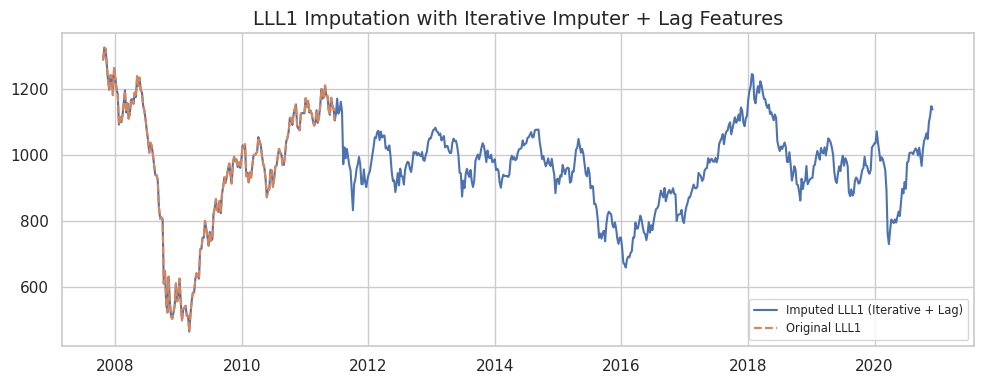

In [64]:
# Infer missing data for LLL1 using IterativeImputer with lagged features.
LLL1_imputed_series = impute_series_with_lag(
    df=df_raw,
    target_col="LLL1",
    corruption_start_idx=192,
    lag = 20
)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(df_raw.index, LLL1_imputed_series, label="Imputed LLL1 (Iterative + Lag)")
plt.plot(df_raw.index[:192], df_raw["LLL1"].iloc[:192], label="Original LLL1", linestyle="--")
plt.title("LLL1 Imputation with Iterative Imputer + Lag Features")
plt.legend(fontsize='x-small')
plt.tight_layout()
plt.show()

# Replace the corrupted column in the df and save
df_cleaned = df_raw.copy()
df_cleaned["LLL1"] = LLL1_imputed_series
df_cleaned.to_parquet("data/processed/df_cleaned_imp_LLL1.parquet", index=True)


# PUSH

In [1]:
!curl -fsSL https://cli.github.com/packages/githubcli-archive-keyring.gpg | sudo dd of=/usr/share/keyrings/githubcli-archive-keyring.gpg > /dev/null
!sudo chmod go+r /usr/share/keyrings/githubcli-archive-keyring.gpg > /dev/null
!echo "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/githubcli-archive-keyring.gpg] https://cli.github.com/packages stable main" | sudo tee /etc/apt/sources.list.d/github-cli.list > /dev/null
!sudo apt update > /dev/null
!sudo apt install gh -y > /dev/null


4+1 records in
4+1 records out
2270 bytes (2.3 kB, 2.2 KiB) copied, 0.305822 s, 7.4 kB/s




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [65]:
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

In [66]:
from getpass import getpass
import os

# 1. Get your GitHub Personal Access Token securely
token = getpass("Paste your GitHub Personal Access Token: ")
os.environ['GITHUB_TOKEN'] = token

# 2. Set your GitHub repo details
GITHUB_USERNAME = "jacopo-raffaeli"
REPO_NAME = "portfolio-replica"
BRANCH = "main"

# 3. Construct remote URL with token embedded (hidden from output)
remote_url = f"https://{token}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"

# 4. Set git user info (if not done already)
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

# 5. Change remote origin URL to token-embedded one
!git remote set-url origin {remote_url}


Paste your GitHub Personal Access Token: ··········


In [67]:
# 6. Add and commit changes (customize your commit message)
!git add .
!git commit -m "feat: Add Initial EDA" || echo "No changes to commit."

# 7. Push to GitHub
!git push origin {BRANCH}

[main 83af8a3] feat: Add Initial EDA
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 data/processed/df_cleaned_imp_LLL1.parquet
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 45.85 KiB | 6.55 MiB/s, done.
Total 5 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/jacopo-raffaeli/portfolio-replica.git
   12a318f..83af8a3  main -> main


In [68]:
# Show git status, which files are changed and staged
!git status

# Show last commit files changed (to check if notebook was included)
!git show --name-only --oneline -1

# Show current branch
!git branch

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
83af8a3 (HEAD -> main, origin/main, origin/HEAD) feat: Add Initial EDA
data/processed/df_cleaned_imp_LLL1.parquet
* main
